In [1]:
# Import python packages
%matplotlib inline
import katdal
import datetime
import numpy
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import matplotlib.dates as mdates

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/usr/local/lib/python2.7/dist-packages/matplotlib/cbook.py:137: MatplotlibDeprecationWarning: The matplotlib.delaunay module was deprecated in version 1.4. Use matplotlib.tri.Triangulation instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [2]:
# Observation sequence I
moon_obs_files=[
                '/var/kat/archive2/data/MeerKATAR1/telescope_products/2016/09/23/1474604441.h5',
                '/var/kat/archive2/data/MeerKATAR1/telescope_products/2016/09/23/1474606123.h5',
               ]
## Observation sequence II
#moon_obs_files=[
#                '/var/kat/archive2/data/MeerKATAR1/telescope_products/2016/09/23/1474607622.h5',
#                '/var/kat/archive2/data/MeerKATAR1/telescope_products/2016/09/23/1474609128.h5',
#               ]

In [3]:
def moon_obs(filename, pol):

    # Read observation data
    try:
        h5 = katdal.open(filename, quicklook=True)
    except Exception as err_msg: raise SystemExit('An error as occured:\n%s' % err_msg)
    h5.select(reset='T')
    h5.select(corrprods='auto', scans='track', compscans='track')
    track_indices = h5.scan_indices
    ref_ant = h5.ref_ant
    targets = h5.catalogue
    start_time = h5.start_time
    
    # Extract track power and show tracks
    plt.figure(figsize=(10,3))
    next_pointing_idx = 0
    pwr_db = []
    timestamps = []
    for scan_idx in track_indices:
        h5.select(reset='T')
        h5.select(ants=ref_ant, pol=pol, corrprods='auto', scans=scan_idx, compscans='track')
        visibilities = h5.vis[:]
        target= str((targets.targets)[h5.target_indices[0]]).split(',')[0]
        timestamps.append(datetime.datetime.fromtimestamp((numpy.mean(h5.timestamps))))

        track_means = numpy.mean(numpy.abs(visibilities), axis=1)
        pwr_db.append(10.*numpy.log10(numpy.mean(track_means)))
        pointings = numpy.arange(next_pointing_idx, next_pointing_idx+numpy.sum(numpy.shape(visibilities)[0]))
        next_pointing_idx = pointings[-1]
        plt.plot(pointings, 10.*numpy.log10(track_means), '.-', label=target)

    plt.axis('tight')
    plt.legend(bbox_to_anchor=(0.5, -0.2), loc=9, ncol=3)
    plt.title('Ref Ant %s%s: avg power per track = %s dB' % (ref_ant, pol, ','.join(['%.2f'%(10.*numpy.log10(val)) for val in pwr_db])))
    plt.xlabel('Pointings [#] @ %s'%str(start_time))
    plt.ylabel('Power [arb dB]')
    
    return [ref_ant, timestamps, pwr_db]

H pol track of reference antennas


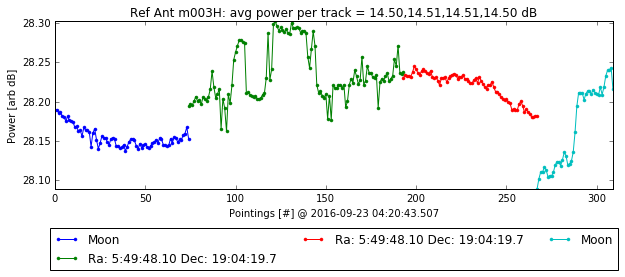

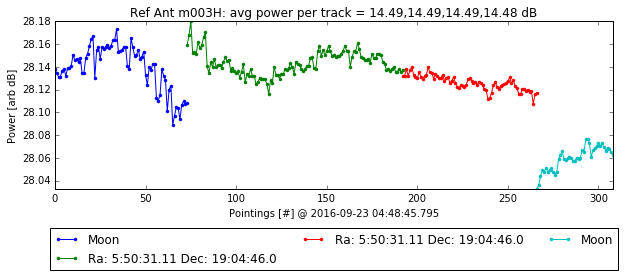

In [4]:
print 'H pol track of reference antennas'
moontrack_pwr_h = []
obs_times_h = []
for filename in moon_obs_files:
    [ref_ant, timestamps, pwr_db] = moon_obs(filename, 'H')
    obs_times_h.append(timestamps)
    moontrack_pwr_h.append(pwr_db)

V pol track of reference antennas


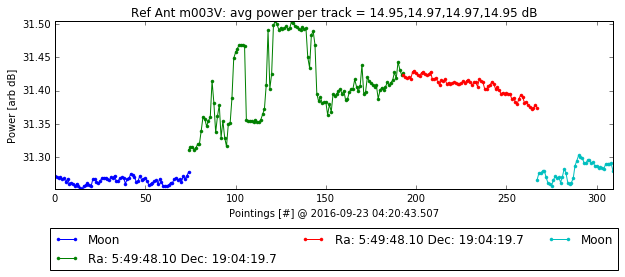

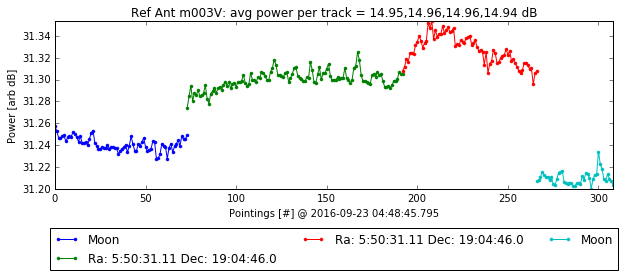

In [5]:
print 'V pol track of reference antennas'
moontrack_pwr_v = []
obs_times_v = []
for filename in moon_obs_files:
    [ref_ant, timestamps, pwr_db] = moon_obs(filename, 'V')
    obs_times_v.append(timestamps)
    moontrack_pwr_v.append(pwr_db)

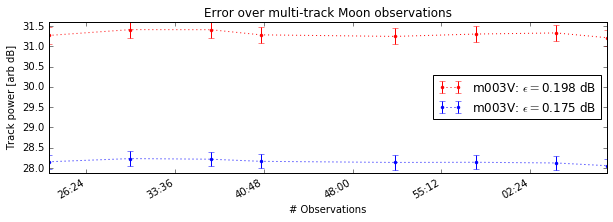

In [6]:
[nr,nc]=numpy.shape(moontrack_pwr_h)
moontrack_pwr_h = numpy.reshape(moontrack_pwr_h,(1,nr*nc)).flatten()
herr = max(moontrack_pwr_h) - min(moontrack_pwr_h)
[nr,nc]=numpy.shape(moontrack_pwr_v)
moontrack_pwr_v = numpy.reshape(moontrack_pwr_v,(1,nr*nc)).flatten()
verr = max(moontrack_pwr_v) - min(moontrack_pwr_v)

[nr,nc]=numpy.shape(obs_times_h)
obs_times_h = numpy.reshape(obs_times_h,(1,nr*nc)).flatten()
obs_dates = [dates.datestr2num(dt.strftime('%Y-%m-%d %H:%M:%S')) for dt in obs_times_h]

plt.figure(figsize=(10,3))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%M:%S'))
plt.errorbar(obs_dates, moontrack_pwr_v, yerr=verr, fmt='r.:', label='%sV: $\epsilon=$%.3f dB'%(ref_ant,verr))
plt.errorbar(obs_dates, moontrack_pwr_h, yerr=herr, fmt='b.:', label='%sV: $\epsilon=$%.3f dB'%(ref_ant,herr))
plt.gcf().autofmt_xdate()
plt.axis('tight')
plt.xlabel('# Observations')
plt.ylabel('Track power [arb dB]')
plt.legend(loc=0)
plt.title('Error over multi-track Moon observations')